In [1]:
import numpy as np
import emcee
import scipy.stats as stats
import scipy
import matplotlib.pyplot as pl
import pandas as pd
from scipy.interpolate import interp1d, griddata, interpn
from scipy import ndimage

## MCMC - example

In [2]:
n = 100
k = 66
p = k/n

a, b   = 5, 17
thetas = np.linspace(0, 1, 200)

In [3]:
alpha = a
beta  = b

In [4]:
def log_prior(theta):
    a,b = 5,17
    if (theta<0 or theta>1):
        return -np.inf
    return np.log(scipy.stats.beta.pdf(theta,a,b))

def log_Binomial(theta):
    k, n = 61,100
    res = stats.binom.logpmf(k,n,theta)
    if res != 0:
        return res
    else:
        return -np.inf

def log_post(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_Binomial(theta)

In [5]:
ndim, nwalkers = 1, 2
p0 = [np.random.rand(ndim)*0.1+0.4 for i in range(nwalkers)]

In [6]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
nburn  = 10
nsteps = 2000
state = sampler.run_mcmc(p0, nburn)
sampler.reset()
sampler.run_mcmc(state, nsteps);

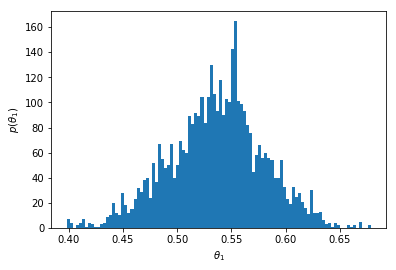

In [7]:
samples = sampler.get_chain(flat=True)
pl.hist(samples[:, 0], 100)
pl.xlabel(r"$\theta_1$");
pl.ylabel(r"$p(\theta_1)$");

In [8]:
np.shape(sampler.chain[:, :, :]) # nwalkers x nsteps x ndim

(2, 2000, 1)

In [9]:
np.shape(samples)

(4000, 1)

## LLH function

In [10]:
d = np.linspace(36, 39, 2, endpoint=True)
wave = np.load("wave.npy")[0]
data = np.load("grid_data.npy")
xspec = pd.read_csv('../TARDIS/AT2017gfo_Phase1.dat',usecols=[0,1,3], delimiter='\t',header=None,skiprows=1)

In [11]:
new_p = np.zeros((2,2,2,2,2),dtype=object)
new_data = np.zeros((2,2,2,2,2),dtype=object)
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                for m in range(2):
                    new_p[i,j,k,l,m] = np.append(d[i],data[0,j,k,l,m])
                    new_data[i,j,k,l,m] = data[1,j,k,l,m]/((1+0.0099)*4*np.pi*(d[i]*3.08567758128E+24)**2)

final_data = np.stack([new_p,new_data])

In [12]:
obs_err = xspec[3][xspec[0].notna()]
obs = xspec[1][xspec[0].notna()]

llh = np.zeros_like(final_data[1], dtype=float)
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                for m in range(2):
                    spline = interp1d(wave, final_data[1,i,j,k,l,m][0]) #OBS linear spline
                    exp = spline(xspec[0][xspec[0].notna()])
                    llh[i,j,k,l,m] = -1/2*np.sum((obs-exp)**2/(2*(obs_err)**2)+np.log(2*np.pi*(obs_err)**2))

In [13]:
print((final_data[0][np.where(llh == np.max(llh))]))
print(([np.where(llh == np.max(llh))]))

[array([3.60000000e+01, 3.11111111e+41, 2.00000000e-16, 1.00000000e+08,
       1.06000000e+08])]
[(array([0]), array([1]), array([0]), array([1]), array([1]))]


In [14]:
d = np.linspace(final_data[0][0,0,0,0,0][0], final_data[0][1,1,1,1,1][0], 2)
l = np.linspace(final_data[0][0,0,0,0,0][1], final_data[0][1,1,1,1,1][1], 2)
rho = np.linspace(final_data[0][0,0,0,0,0][2], final_data[0][1,1,1,1,1][2], 2)
vstart = np.linspace(final_data[0][0,0,0,0,0][3], final_data[0][1,1,1,1,1][3], 2)
vstop = np.linspace(final_data[0][0,0,0,0,0][4], final_data[0][1,1,1,1,1][4], 2)

points = (d,l,rho,vstart,vstop)

In [15]:
point = np.array([37, 3.1e41, 2.1e-16, 0.8e8, 1.04e8])
point = np.array([3.90000000e+01, 3.00000000e+41, 2.11111111e-16, 1.00000000e+08,1.02000000e+08])
print(interpn(points, llh, point))

[420974.5357193]


## MCMC

In [16]:
def log_prior(theta):
#    d,l,rho,vstart,vstop = theta
    if (theta[0]<d[0] or theta[0]>d[-1]):
        return -np.inf
    elif (theta[1]<l[0] or theta[1]>l[-1]):
        return -np.inf
    elif (theta[2]<rho[0] or theta[2]>rho[-1]):
        return -np.inf
    elif (theta[3]<vstart[0] or theta[3]>vstart[-1]):
        return -np.inf
    elif (theta[4]<vstop[0] or theta[4]>vstop[-1]):
        return -np.inf
    return 0.0

def log_llh(theta):
#     d,l,rho,vstart,vstop = theta
#     param = np.array([theta])
#     res = interpn(points, llh, param) # linear spline
    d_i = (theta[0]-d[0])/(d[1]-d[0])*(len(d)-1)
    l_i = (theta[1]-l[0])/(l[1]-l[0])*(len(l)-1)
    rho_i = (theta[2]-rho[0])/(rho[1]-rho[0])*(len(rho)-1)
    vstart_i = (theta[3]-vstart[0])/(vstart[1]-vstart[0])*(len(vstart)-1)
    vstop_i = (theta[4]-vstop[0])/(vstop[1]-vstop[0])*(len(vstop)-1)    
    res = ndimage.map_coordinates(llh, [[d_i],[l_i],[rho_i],[vstart_i],[vstop_i]])
    if res != 0:
        return res
    else:
        return -np.inf

def log_post(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_llh(theta)

In [17]:
ndim, nwalkers = 5, 30

d0 = np.random.uniform(d[0],d[-1],size=nwalkers)
l0 = np.random.uniform(l[0],l[-1],size=nwalkers)
rho0 = np.random.uniform(rho[0],rho[-1],size=nwalkers)
vstart0 = np.random.uniform(vstart[0],vstart[-1],size=nwalkers)
vstop0 = np.random.uniform(vstop[0],vstop[-1],size=nwalkers)

p0 = []
for i in range(nwalkers):
    p0.append(np.array([d0[i],l0[i],rho0[i],vstart0[i],vstop0[i]]))

In [18]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
nburn  = 100
nsteps = 2000
state = sampler.run_mcmc(p0, nburn)
sampler.reset()
sampler.run_mcmc(state, nsteps, progress = True);

100%|██████████| 2000/2000 [00:05<00:00, 363.59it/s]


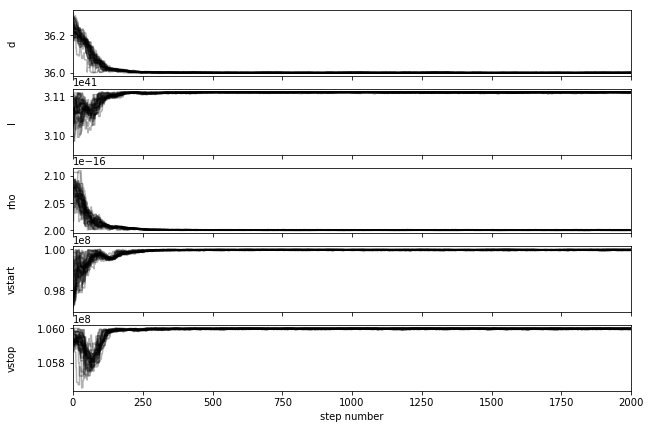

In [19]:
fig, axes = pl.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["d", "l", "rho", "vstart", "vstop"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

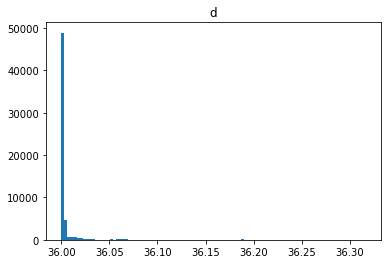

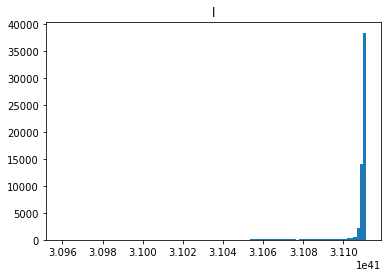

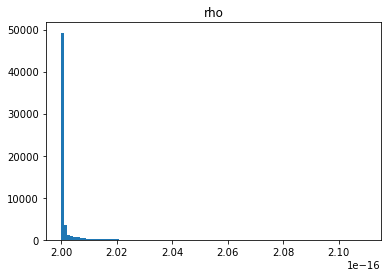

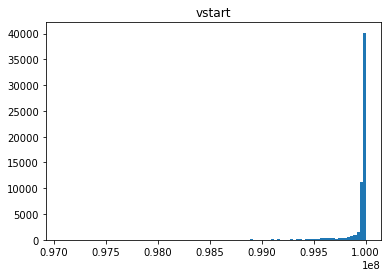

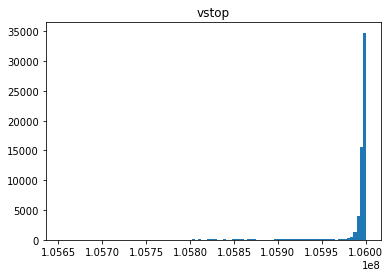

In [20]:
samples = sampler.get_chain(flat=True)
for i in range(ndim):
    pl.hist(samples[:, i], 100)
    pl.title(labels[i])
    pl.show()

In [25]:
# tau = sampler.get_autocorr_time()
# print(tau)

In [22]:
obs = xspec[1][xspec[0].notna()]
spline = interp1d(wave, final_data[1][0,1,0,1,1][0])
exp = spline(xspec[0][xspec[0].notna()])

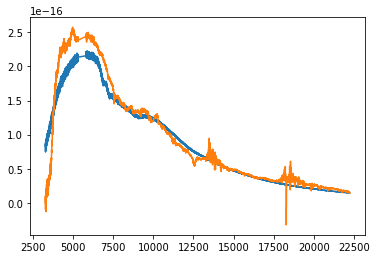

In [23]:
pl.plot(xspec[0][xspec[0].notna()],exp);
pl.plot(xspec[0][xspec[0].notna()],obs)